<a href="https://colab.research.google.com/github/guilhermelaviola/CustomerSegmentationModel/blob/main/CustomerChurnPredictionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Importing Pandas library, loading and displaying the dataset
import pandas as pd

df = pd.read_csv('data.csv', encoding = 'unicode_escape')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [2]:
# There are 8 different variables in the dataframe: InvoiceNo, StockCode,
# Description, Quantity, InvoiceDate, UnitPrice, CustomerID and Country
# With the transaction data, we need to build different customer segments
# based on each user purchase behavior

# Before taking any further step, we need to prepare the data
# The informative features in the dataset that tells us aboyt the customer
# buying behavior are Quantity, InvoiveDate and UnitPrice.
# With these variables we cab derive the customer's RFM (Recency, Frequency,
# Monetary Value) profile.
# These variables will be used to build a segmentation model.

# Calculating recency:
# Converting the date column into datetime format
df['Date']= pd.to_datetime(df['InvoiceDate'])

In [4]:
# Keeping the most recent date of purchase only
df['rank'] = df.sort_values(['CustomerID','Date']).groupby(['CustomerID'])['Date'].rank(method='min')
df_rec = df[df['rank'] == 1]

In [6]:
# Assigning a recency score ro each CustomerID.
df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days

<ipython-input-6-69b0b5db1d95>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rec['recency'] = (df_rec['Date'] - pd.to_datetime(min(df_rec['Date']))).dt.days


In [7]:
# Now it's time to calculate the frequency, in other words, how many times each
# customer made a purchase on the platform
freq = df_rec.groupby('CustomerID')['Date'].count()
df_freq = pd.DataFrame(freq).reset_index()
df_freq.columns = ['CustomerID', 'frequency']

# The new dataframe that was just created contains two columns: 'CustomerID'
# and 'frequency'. Let's merge this dataframe with the previous one:
rec_freq = df_freq.merge(df_rec, on = 'CustomerID')

In [10]:
# Displaying the dataframe, for testing
rec_freq.head(10)

,CustomerID,frequency,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,Country,Date,rank,recency
0,12347.0,31,537626,85116,BLACK CANDELABRA T-LIGHT HOLDER,12,12/7/2010 14:57,2.10,Iceland,2010-12-07 14:57:00,1.0,6
1,12347.0,31,537626,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,12/7/2010 14:57,4.25,Iceland,2010-12-07 14:57:00,1.0,6
2,12347.0,31,537626,71477,COLOUR GLASS. STAR T-LIGHT HOLDER,12,12/7/2010 14:57,3.25,Iceland,2010-12-07 14:57:00,1.0,6
3,12347.0,31,537626,22492,MINI PAINT SET VINTAGE,36,12/7/2010 14:57,0.65,Iceland,2010-12-07 14:57:00,1.0,6
4,12347.0,31,537626,22771,CLEAR DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
5,12347.0,31,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
6,12347.0,31,537626,22773,GREEN DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
7,12347.0,31,537626,22774,RED DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
8,12347.0,31,537626,22775,PURPLE DRAWERKNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6
9,12347.0,31,537626,22805,BLUE DRAWER KNOB ACRYLIC EDWARDIAN,12,12/7/2010 14:57,1.25,Iceland,2010-12-07 14:57:00,1.0,6


In [11]:
# Calculating each user's monetary value (mv) to understand the total amount
# the customers have spent in the platform
rec_freq['total'] = rec_freq['Quantity']*df['UnitPrice']
mv = rec_freq.groupby('CustomerID')['total'].sum()
mv = pd.DataFrame(mv).reset_index()
mv.columns = ['CustomerID', 'monetary_value']

In [ ]:
# The new dataframe taht was just created consists of each CustomerID and
# its associated monetary value.
# Merging it with the main dataframe
rfm = mv.merge(rec_freq, on = 'CustomerID')

# Displaying the new dataframe that was just created
rfm.head()

In [19]:
# Selecting only the necessary columns to build the customer
# segmentation model
finaldf = rfm[['CustomerID', 'recency', 'frequency', 'monetary_value']]

In [20]:
# Now it's time to remove the outliers, before finally building the
# customer segmentation model.

# But first, we need to import the necessary libraries for it
import seaborn as sns
import matplotlib.pyplot as plt

recency: 


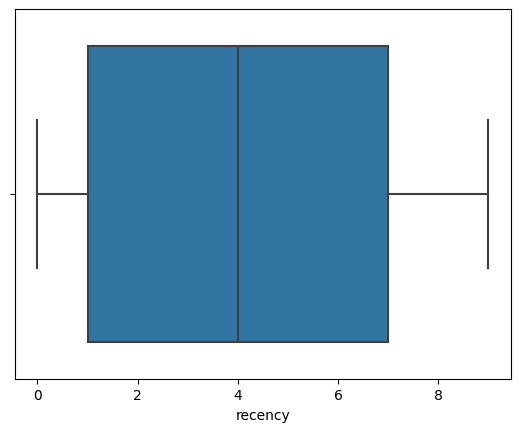

frequency: 


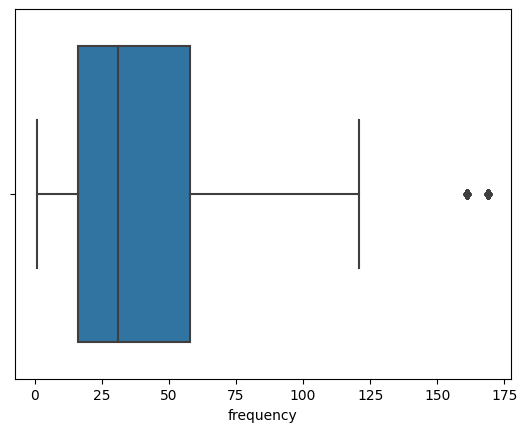

monetary_value: 


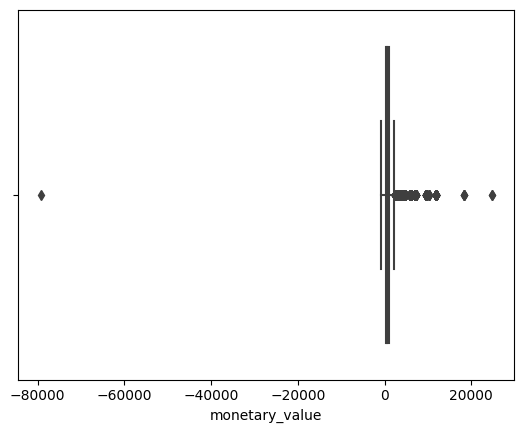

In [21]:
# First need to check the dataframe for outliers and remove them.
# In order to get a visual representation of outliers in the dataframe,
# we create a boxplot of each variable.
list1 = ['recency', 'frequency', 'monetary_value']
for i in list1:
    print(str(i) + ': ')
    ax = sns.boxplot(x = finaldf[str(i)])
    plt.show()